In [2]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
# Import useful libraries
import pandas as pd
import numpy as np
import math

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png" # Comment / delete this line for interactive graphs

import warnings
warnings.filterwarnings("ignore")

In [4]:
delay_data = pd.read_excel("https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx", sheet_name = "rentals_data")
doc = pd.read_excel("https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx", sheet_name = "Documentation")

**Data exploration and cleaning**

In [5]:
print(f"Number of rows : {delay_data.shape[0]}")
print(f"Number of columns : {delay_data.shape[1]}")
print()

print("Display of data: ")
display(delay_data.head(10))
print()

print("Basics statistics: ")
display(delay_data.describe(include='all'))
print()
pd.options.display.max_rows = 999
print("Percentage of missing values: ")
display((100 * delay_data.isnull().sum() /delay_data.shape[0]).sort_values())

Number of rows : 21310
Number of columns : 7

Display of data: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN
5,511626,398802,mobile,ended,-203.0,NaN,NaN
6,511639,370585,connect,ended,-15.0,563782.0,570.0
7,512303,371242,mobile,ended,-44.0,NaN,NaN
8,512475,322502,mobile,canceled,NaN,NaN,NaN
9,513434,256528,connect,ended,23.0,NaN,NaN



Basics statistics: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000



Percentage of missing values: 


rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

There are a lot of missing values in 'previous_ended_rental_id' and 'time_delta_with_previous_rental_in_minutes' columns. These columns give information about previous rental that happenned less that 12 hours before the actual rental. It means that in our dataset, 91% of the rentals happenned more than 12 hours after the previous rental.

There are also 23% of missing values in the 'delay_at_checkout_in_minutes' column.

## Missing Values

In [6]:
# Check if any values in the "delay_at_checkout_in_minutes" are equal to 0
zero_delay_count = (delay_data['delay_at_checkout_in_minutes'] == 0).sum()

print("Number of values equal to 0 in delay_at_checkout_in_minutes column:", zero_delay_count)

Number of values equal to 0 in delay_at_checkout_in_minutes column: 122


We cannot delete'NaN' values in the 'delay_at_checkout_in_minutes' column as this would delete the cancel value in 'status' which might be usefull.
We will replace the missing values with 'unknown'.

In [7]:
# Create new column 'delay' from 'delay_at_checkout_in_minutes' column.
# Define the conditions and labels
conditions = [
    (delay_data['delay_at_checkout_in_minutes'] <= 0),
    (delay_data['delay_at_checkout_in_minutes'] < 60),
    (delay_data['delay_at_checkout_in_minutes'] < 120),
    (delay_data['delay_at_checkout_in_minutes'] < 300),
    (delay_data['delay_at_checkout_in_minutes'] < 1440),
    (delay_data['delay_at_checkout_in_minutes'] >= 1440),
    (delay_data['delay_at_checkout_in_minutes'].isna())
]

labels = ['Early or On Time', '< 1 Hour', '1 to 2 Hours', '2 to 5 Hours', '5 to 24 Hours', '1 day or more', 'Unknown']

# Create the 'delay' column based on the conditions and labels
delay_data['delay'] = np.select(conditions, labels)

# Calculate the value counts of each delay category
delay_counts = delay_data['delay'].value_counts()

# Calculate the percentage of each category
delay_percentages = (delay_counts / delay_counts.sum()) * 100

# Display the result
print(delay_percentages)

Early or On Time    32.576255
< 1 Hour            23.350540
Unknown             23.294228
1 to 2 Hours         8.728297
2 to 5 Hours         7.114031
5 to 24 Hours        4.049742
1 day or more        0.886908
Name: delay, dtype: float64


In [8]:
delay_data.shape

(21310, 8)

## Outliers

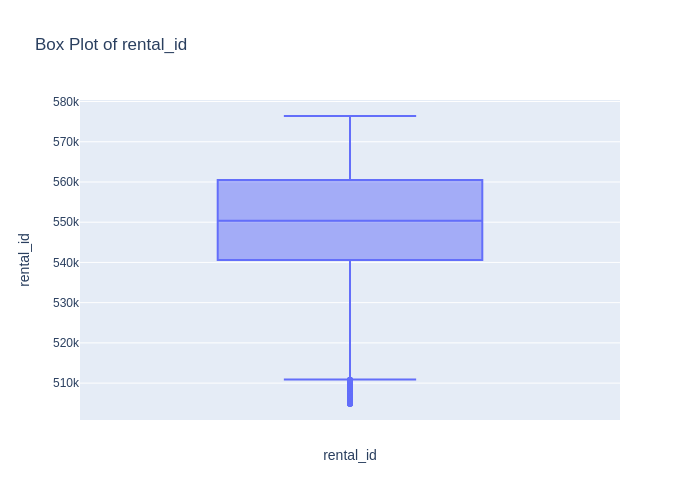

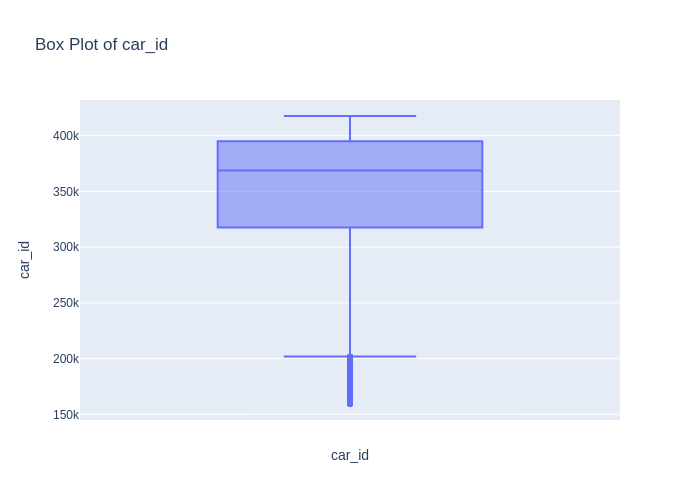

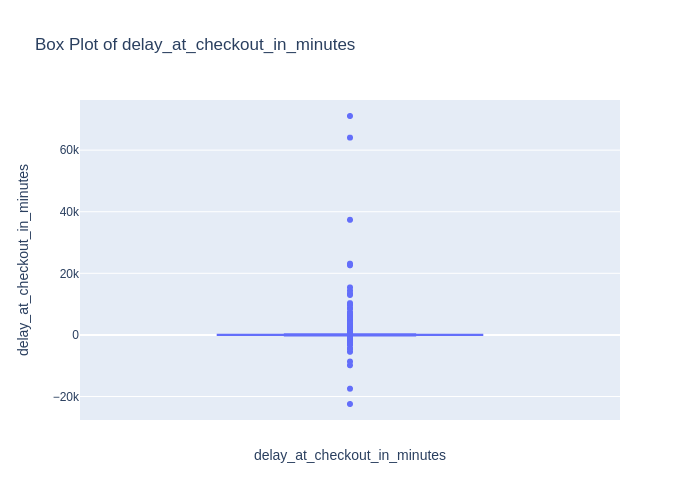

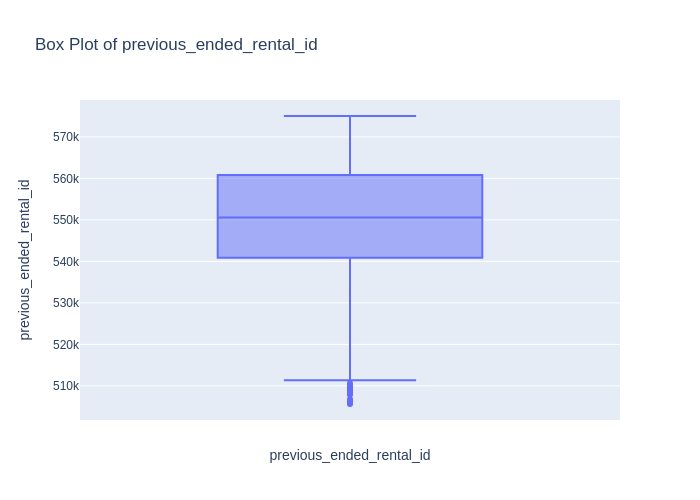

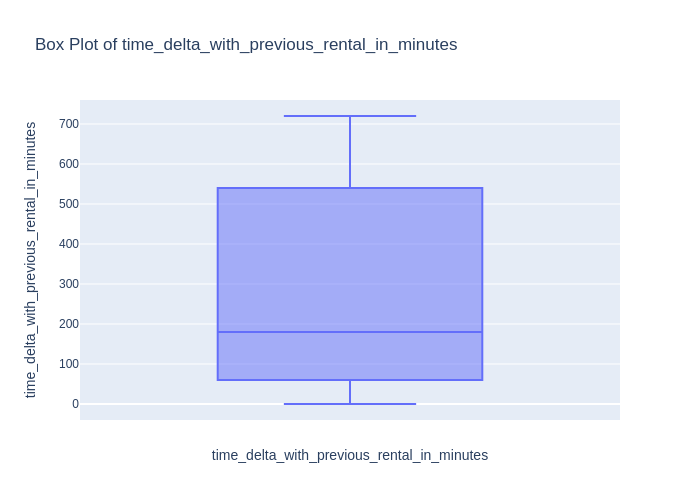

In [9]:
# Create box plots for all numeric columns in the dataset
for column in delay_data.select_dtypes(include=['number']).columns:
    fig = px.box(delay_data, y=column, title=f'Box Plot of {column}')
    fig.update_xaxes(title_text=column)
    fig.show()


There are some outliers in the 'delay_at_checkout_in_minutes'. Let's delete all datas that were more than 5 days late for checkout.

In [10]:
# Count the number of entries with delay_at_checkout_in_minutes > 7200
outlier_entries = delay_data[delay_data['delay_at_checkout_in_minutes'] > 7200]

# Get the count of such entries
num_outliers = len(outlier_entries)

# Display the count
print("Number of entries with delay_at_checkout_in_minutes > 7200:", num_outliers)

# Filter out and remove the outliers
delay_data = delay_data[(delay_data['delay_at_checkout_in_minutes'] <= 7200) | (delay_data['delay_at_checkout_in_minutes'].isna())]

# Check the shape of the DataFrame after removing outliers
print("Shape of delay_data after removing outliers:", delay_data.shape)

Number of entries with delay_at_checkout_in_minutes > 7200: 15
Shape of delay_data after removing outliers: (21295, 8)


We removed 15 outliers, and kept abnormal values until 5 days late in order to keep the integrity of the data.

## Duplicated values

In [11]:
# Check duplicated values
delay_data.duplicated(subset=None, keep='first').value_counts()

False    21295
dtype: int64

## EDA - visualizations

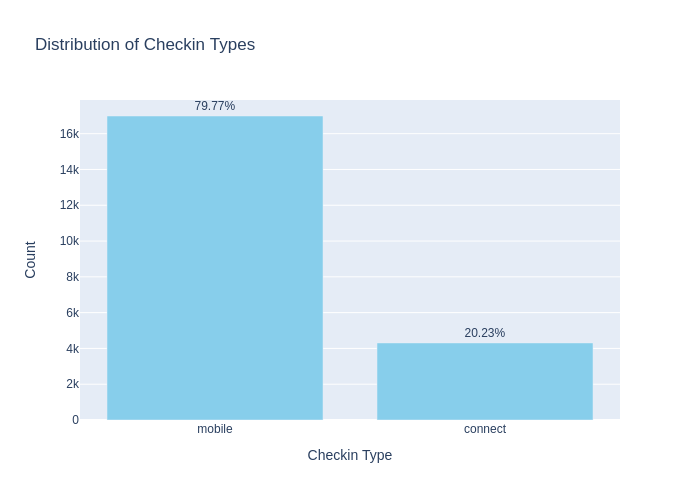

In [12]:

# Bar chart for 'checkin_type'
checkin_type_counts = delay_data['checkin_type'].value_counts()
checkin_type_percentage = (checkin_type_counts / checkin_type_counts.sum()) * 100

fig2 = px.bar(
    x=checkin_type_counts.index,
    y=checkin_type_counts,
    title='Distribution of Checkin Types',
    labels={'x': 'Checkin Type', 'y': 'Count'},
)
fig2.update_traces(marker_color='skyblue')

# Add tags with percentages
percentage_text = [f'{p:.2f}%' for p in checkin_type_percentage]
fig2.update_traces(marker_color='skyblue', text=percentage_text, textposition='outside')


fig2.update_yaxes(title='Count')

fig2.show()

Only 20% of rentals are booked from Connect cars.

# How often are drivers late for the next check-in? How does it impact the next driver?

In [13]:
# Calculate the total number of entries in the dataset
total_entries = len(delay_data)

# Calculate the number of late returns (positive values)
late_returns_count = len(delay_data[delay_data['delay_at_checkout_in_minutes'] > 0])

# Calculate the number of NaN values
nan_count = delay_data['delay_at_checkout_in_minutes'].isna().sum()

# Check the number of 'on time' or 'earlier' values
on_time_or_earlier_count = len(delay_data[delay_data['delay_at_checkout_in_minutes'] <= 0])

# Calculate the percentage of late returns
late_return_percentage = (late_returns_count / total_entries) * 100

# Calculate the percentage of on time/earlier returns
on_time_percentage = (on_time_or_earlier_count / total_entries) * 100

# Calculate the percentage of NaNs
NaN_percentage = (nan_count / total_entries) * 100

# Display the result
print("Total Number of Entries:", total_entries)
print("Number of Late Returns (excluding NaN as negative):", late_returns_count)
print("Number of On Time or Earlier Returns:", on_time_or_earlier_count)
print("Number of NaN Values:", nan_count)
print("Percentage of Late Returns :", late_return_percentage)
print("Percentage of On Time/Early Returns :", on_time_percentage)
print("Percentage of NaN :", NaN_percentage)

Total Number of Entries: 21295
Number of Late Returns (excluding NaN as negative): 9389
Number of On Time or Earlier Returns: 6942
Number of NaN Values: 4964
Percentage of Late Returns : 44.09016200986147
Percentage of On Time/Early Returns : 32.59920169053768
Percentage of NaN : 23.310636299600844


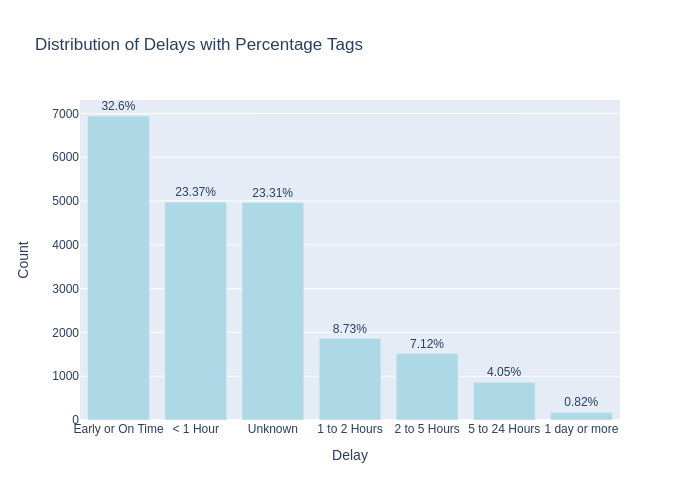

In [14]:
# Calculate the counts and percentages of each delay category
delay_counts = delay_data['delay'].value_counts()
delay_percentages = (delay_counts / delay_counts.sum()) * 100

# Create a histogram manually
fig3 = go.Figure(data=[
    go.Bar(
        x=delay_counts.index,
        y=delay_counts,
        text=delay_percentages.round(2).astype(str) + '%',  # Add percentage to the text
        textposition='outside',  # Show text outside the bars
        marker=dict(color='lightblue'),  # Customize bar color
    )
])

# Customize the layout
fig3.update_layout(
    title='Distribution of Delays with Percentage Tags',
    xaxis=dict(title='Delay'),
    yaxis=dict(title='Count'),
    showlegend=False,
)

fig3.show()

32% of the rental end well as the user checks out earlier or on time, and 44% of them check out late.

We don't have any information about the delay for 23% of our dataset.

Among the users that check out late, more than 50% are "only" one hour or less late.

In [15]:
# Calculate the frequency of late check-ins
late_checkins = delay_data[delay_data['delay_at_checkout_in_minutes'] > 0]
late_checkin_frequency = (len(late_checkins) / len(delay_data)) * 100

print("Percentage of late check-ins:", late_checkin_frequency)

# Analyze the impact on the next driver

average_delay = late_checkins['time_delta_with_previous_rental_in_minutes'].mean()
max_delay = late_checkins['time_delta_with_previous_rental_in_minutes'].max()
min_delay = late_checkins['time_delta_with_previous_rental_in_minutes'].min()

print("Average delay in minutes for the next driver:", average_delay)
print("Maximum delay in minutes for the next driver:", max_delay)
print("Minimum delay in minutes for the next driver:", min_delay)

Percentage of late check-ins: 44.09016200986147
Average delay in minutes for the next driver: 259.58801498127343
Maximum delay in minutes for the next driver: 720.0
Minimum delay in minutes for the next driver: 0.0


Let's check which delays had a negative impact on the next rental. Here we want to highlight the rentals that couldn't start on time because the previous rental was checked out later that the new check in rental.

In [16]:
# Create a new DataFrame 'test_df' by merging on 'previous_ended_rental_id'
merge_id_df = delay_data.merge(
    delay_data[['rental_id']],
    left_on='previous_ended_rental_id',
    right_on='rental_id',
    how='inner'
)

# Calculate the new column 'delta_previous_and_delay'
merge_id_df['delta_previous_and_delay'] = merge_id_df['time_delta_with_previous_rental_in_minutes'] - merge_id_df['delay_at_checkout_in_minutes']

# Select rows where 'delta_previous_and_delay' values are strictly negative
negative_delta_rows = merge_id_df[merge_id_df['delta_previous_and_delay'] < 0]

# Display the selected rows
display(negative_delta_rows.head())
print(f"Shape of negative_delta_rows dataset : {negative_delta_rows.shape}")

,rental_id_x,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,delay,rental_id_y,delta_previous_and_delay
8,535770,352436,mobile,ended,74.0,524703.0,60.0,1 to 2 Hours,524703,-14.0
9,537576,397470,mobile,ended,18.0,539005.0,0.0,< 1 Hour,539005,-18.0
11,540479,374684,mobile,ended,12.0,539751.0,0.0,< 1 Hour,539751,-12.0
12,541862,382364,mobile,ended,125.0,540607.0,0.0,2 to 5 Hours,540607,-125.0
18,543808,369230,mobile,ended,75.0,536315.0,60.0,1 to 2 Hours,536315,-15.0


Shape of negative_delta_rows dataset : (269, 10)


Here the 'delta_previous_and_delay' columns shows the delta in minutes between the time between 2 rentals, and the delay of the previous rental. We only select negative values because when negative, it means that the next user didn't have access to its rental on time because the previous user was late for check out.

In [17]:

# Calculate the percentage of problematic delays among all the delays
nb_late_checkins = len(late_checkins)
nb_problematic_delays = negative_delta_rows.shape[0]
problematic_delays_rate = nb_problematic_delays*100/nb_late_checkins
print(f"Among all the delays, {round(problematic_delays_rate, 2)}% of delays caused problems to the next rental because the checkout\n was made later than the new rental checkin.")



Among all the delays, 2.87% of delays caused problems to the next rental because the checkout
 was made later than the new rental checkin.


In [18]:

# Calculate the average duration of problematic delays
average_problematic_delay = negative_delta_rows['delay_at_checkout_in_minutes'].mean()

# Calculate the average duration of non-problematic delays
average_non_problematic_delay = delay_data[delay_data['delay_at_checkout_in_minutes'] > 0]['delay_at_checkout_in_minutes'].mean()

# Compare the averages
print("Average Duration of Problematic Delays:", average_problematic_delay)
print("Average Duration of Non-Problematic Delays:", average_non_problematic_delay)

Average Duration of Problematic Delays: 320.69888475836433
Average Duration of Non-Problematic Delays: 167.08051975716265


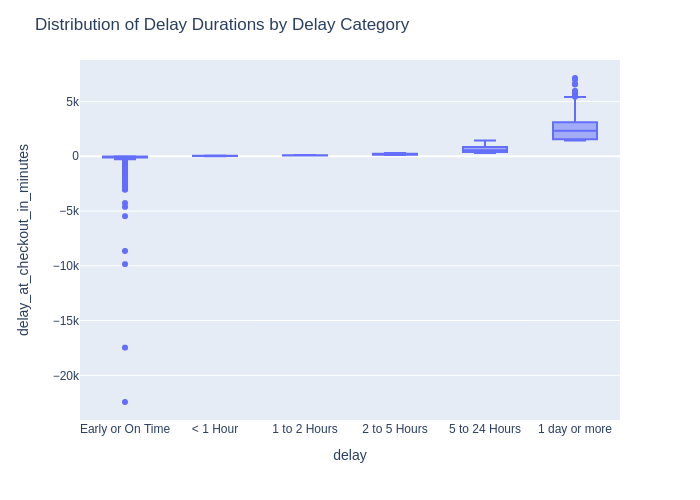

In [19]:
# Filter problematic and non-problematic delays
problematic_delays = delay_data[delay_data['delay_at_checkout_in_minutes'] < 0]
non_problematic_delays = delay_data[delay_data['delay_at_checkout_in_minutes'] >= 0]

# Create a box plot for delay duration
fig = px.box(data_frame=delay_data, x='delay', y='delay_at_checkout_in_minutes',
             category_orders={"delay": ["Early or On Time", "< 1 Hour", "1 to 2 Hours", "2 to 5 Hours", "5 to 24 Hours", "1 day or more", "Unknown"]})

fig.update_layout(title='Distribution of Delay Durations by Delay Category')
fig.show()

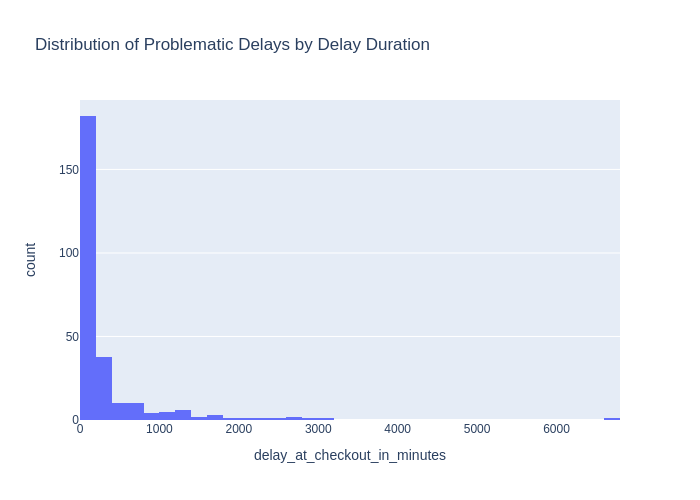

In [20]:
# Create a histogram for problematic delays
fig = px.histogram(data_frame=negative_delta_rows, x='delay_at_checkout_in_minutes',
                   title='Distribution of Problematic Delays by Delay Duration')
fig.show()

Most of the delay durations are under 200 minutes.

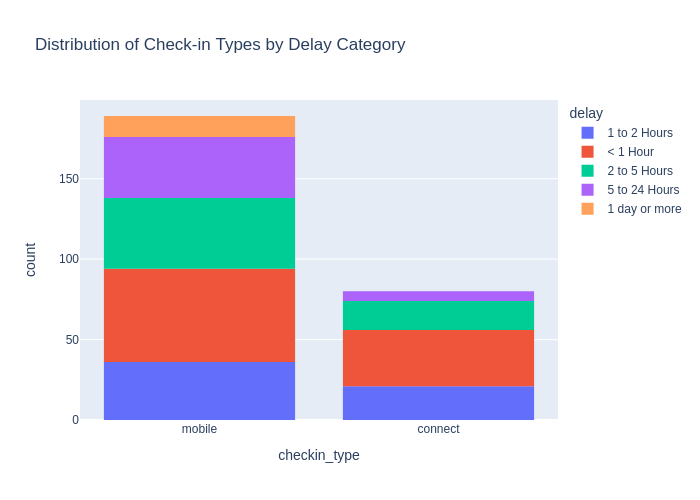

In [21]:
# Create a time-based histogram for check-in times
fig = px.histogram(data_frame=negative_delta_rows, x='checkin_type', color='delay',
                   title='Distribution of Check-in Types by Delay Category')
fig.show()

The worst delays concern the rentals made through the web application.

## Threshold: how long should the minimum delay be?

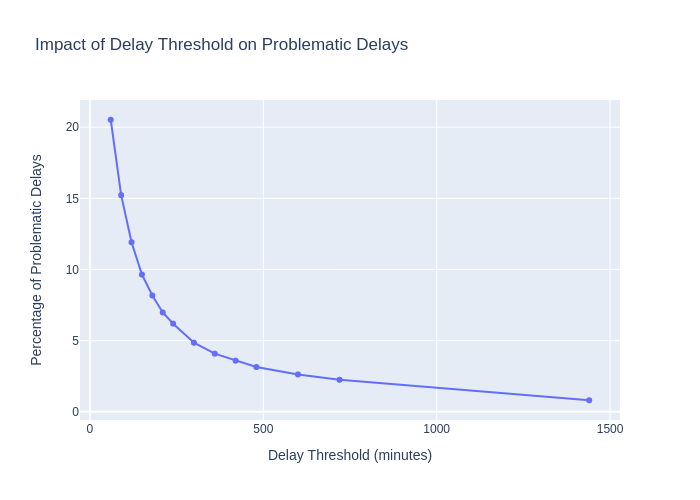

In [22]:
# Group data by delay threshold and calculate the percentage of problematic delays
thresholds = [60, 90, 120, 150, 180, 210, 240, 300, 360, 420, 480, 600, 720, 1440]  # Define different delay thresholds (in minutes)
problematic_rates = []

for threshold in thresholds:
    # Filter data for delays exceeding the threshold
    delayed_rentals = delay_data[delay_data['delay_at_checkout_in_minutes'] > threshold]

    # Calculate the percentage of problematic delays for each threshold
    problematic_rate = (len(delayed_rentals) / len(delay_data)) * 100
    problematic_rates.append(problematic_rate)

# Create a line plot to visualize the impact of different thresholds
fig = px.line(x=thresholds, y=problematic_rates, markers=True, title='Impact of Delay Threshold on Problematic Delays')
fig.update_layout(xaxis_title='Delay Threshold (minutes)', yaxis_title='Percentage of Problematic Delays')
fig.show()

According to this graph, the threshold should be set at 300 minutes (5 hours) so that we hope to get less that 5% of problematic delays.

The delays seem to be more important when check-in occurs through mobile. So we will check if different threshold should be set according on whether check-in occured through mobile or connect.

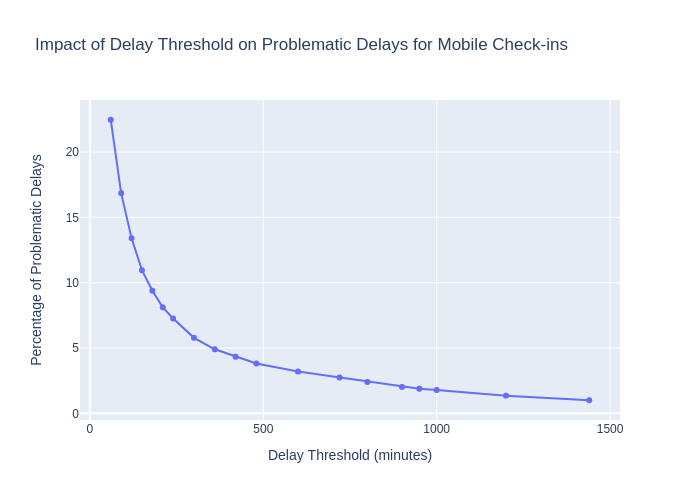

In [23]:

# Filter data for 'mobile' check-ins
mobile_checkins = delay_data[delay_data['checkin_type'] == 'mobile']

# Define different delay thresholds (in minutes)
thresholds = [60, 90, 120, 150, 180, 210, 240, 300, 360, 420, 480, 600, 720, 800, 900, 950, 1000, 1200, 1440]

# Initialize a list to store problematic rates for 'mobile' check-ins
mobile_problematic_rates = []

for threshold in thresholds:
    # Filter 'mobile' check-ins for delays exceeding the threshold
    delayed_mobile_checkins = mobile_checkins[mobile_checkins['delay_at_checkout_in_minutes'] > threshold]

    # Calculate the percentage of problematic delays for each threshold and 'mobile' check-ins
    mobile_problematic_rate = (len(delayed_mobile_checkins) / len(mobile_checkins)) * 100
    mobile_problematic_rates.append(mobile_problematic_rate)

# Create a line plot to visualize the impact of different thresholds for 'mobile' check-ins
fig = px.line(x=thresholds, y=mobile_problematic_rates, markers=True, title='Impact of Delay Threshold on Problematic Delays for Mobile Check-ins')
fig.update_layout(xaxis_title='Delay Threshold (minutes)', yaxis_title='Percentage of Problematic Delays')
fig.show()

For mobile check-in, the most adapted threshold to get less than 2% problematic delays seems to be 950 minutes (more than 15 hours). It seems too high as owners would not be able to rent their car twice in the same day.

If we aim to get less than 5% problematic delays, then the best threshold seems to be 360 minutes (6 hours).

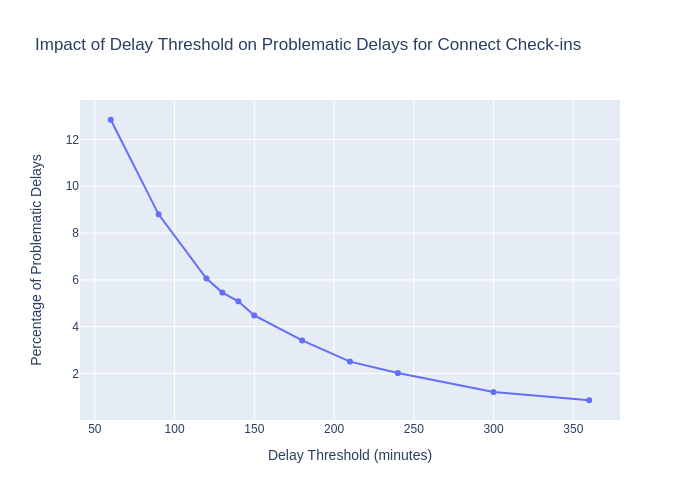

In [24]:
# Filter data for 'connect' check-ins
connect_checkins = delay_data[delay_data['checkin_type'] == 'connect']

# Define different delay thresholds (in minutes)
thresholds = [60, 90, 120, 130, 140, 150, 180, 210, 240, 300, 360]

# Initialize a list to store problematic rates for 'connect' check-ins
connect_problematic_rates = []

for threshold in thresholds:
    # Filter 'connect' check-ins for delays exceeding the threshold
    delayed_connect_checkins = connect_checkins[connect_checkins['delay_at_checkout_in_minutes'] > threshold]

    # Calculate the percentage of problematic delays for each threshold and 'connect' check-ins
    connect_problematic_rate = (len(delayed_connect_checkins) / len(connect_checkins)) * 100
    connect_problematic_rates.append(connect_problematic_rate)

# Create a line plot to visualize the impact of different thresholds for 'connect' check-ins
fig = px.line(x=thresholds, y=connect_problematic_rates, markers=True, title='Impact of Delay Threshold on Problematic Delays for Connect Check-ins')
fig.update_layout(xaxis_title='Delay Threshold (minutes)', yaxis_title='Percentage of Problematic Delays')
fig.show()

On the other hand, for connect check-in, the best threshold to get less than 2% of problematic delays seems to be 250 minutes (a bit more than 4 hours), so much less than the mobile check-ins.

If we aim to get less than 5% problematic delays, the threshold should be set at 150 minutes (2,5 hours).

In conclusion, a different threshold should definitely be set according to the check-in type.

# How many problematic cases will it solve depending on the chosen threshold and scope?

In [25]:
# Define the chosen threshold for mobile and connect check-ins with 5% risk
threshold_mobile_5 = 360  # Minutes for mobile check-ins
threshold_connect_5 = 150  # Minutes for connect check-ins

# Filter data for 'mobile' check-ins with delays below or equal to the threshold
solved_mobile_checkins_5 = negative_delta_rows[
    (negative_delta_rows['checkin_type'] == 'mobile') &
    (negative_delta_rows['delay_at_checkout_in_minutes'] <= threshold_mobile_5)]

# Filter data for 'connect' check-ins with delays below or equal to the threshold
solved_connect_checkins_5 = negative_delta_rows[
    (negative_delta_rows['checkin_type'] == 'connect') &
    (negative_delta_rows['delay_at_checkout_in_minutes'] <= threshold_connect_5)]

# Calculate the number of problematic delays solved for each check-ins
solved_mobile_problems_5 = len(solved_mobile_checkins_5)
solved_connect_problems_5 = len(solved_connect_checkins_5)

# Calculate the percentage of problematic delays solved for each check-in type
total_mobile_problems_5 = len(negative_delta_rows[negative_delta_rows['checkin_type'] == 'mobile'])
total_connect_problems_5 = len(negative_delta_rows[negative_delta_rows['checkin_type'] == 'connect'])

percentage_solved_mobile_5 = (solved_mobile_problems_5 / total_mobile_problems_5) * 100
percentage_solved_connect_5 = (solved_connect_problems_5 / total_connect_problems_5) * 100

# Display the results
print("Number of problematic delays solved for mobile check-ins:", solved_mobile_problems_5)
print("Number of problematic delays solved for connect check-ins:", solved_connect_problems_5)

print("Percentage of problematic delays solved for mobile check-ins:", round(percentage_solved_mobile_5, 2), "%")
print("Percentage of problematic delays solved for connect check-ins:", round(percentage_solved_connect_5, 2), "%")


Number of problematic delays solved for mobile check-ins: 142
Number of problematic delays solved for connect check-ins: 63
Percentage of problematic delays solved for mobile check-ins: 75.13 %
Percentage of problematic delays solved for connect check-ins: 78.75 %


In [26]:
# Define the chosen threshold for mobile and connect check-ins with 5% risk
threshold_mobile_2 = 950  # Minutes for mobile check-ins
threshold_connect_2 = 250  # Minutes for connect check-ins

# Filter data for 'mobile' check-ins with delays below or equal to the threshold
solved_mobile_checkins_2 = negative_delta_rows[
    (negative_delta_rows['checkin_type'] == 'mobile') &
    (negative_delta_rows['delay_at_checkout_in_minutes'] <= threshold_mobile_2)]

# Filter data for 'connect' check-ins with delays below or equal to the threshold
solved_connect_checkins_2 = negative_delta_rows[
    (negative_delta_rows['checkin_type'] == 'connect') &
    (negative_delta_rows['delay_at_checkout_in_minutes'] <= threshold_connect_2)]

# Calculate the number of problematic delays solved for each check-ins
solved_mobile_problems_2 = len(solved_mobile_checkins_2)
solved_connect_problems_2 = len(solved_connect_checkins_2)

# Calculate the percentage of problematic delays solved for each check-in type
total_mobile_problems_2 = len(negative_delta_rows[negative_delta_rows['checkin_type'] == 'mobile'])
total_connect_problems_2 = len(negative_delta_rows[negative_delta_rows['checkin_type'] == 'connect'])

percentage_solved_mobile_2 = (solved_mobile_problems_2 / total_mobile_problems_2) * 100
percentage_solved_connect_2 = (solved_connect_problems_2 / total_connect_problems_2) * 100

# Display the results
print("Number of problematic delays solved for mobile check-ins:", solved_mobile_problems_2)
print("Number of problematic delays solved for connect check-ins:", solved_connect_problems_2)

print("Percentage of problematic delays solved for mobile check-ins:", round(percentage_solved_mobile_2, 2), "%")
print("Percentage of problematic delays solved for connect check-ins:", round(percentage_solved_connect_2, 2), "%")


Number of problematic delays solved for mobile check-ins: 163
Number of problematic delays solved for connect check-ins: 72
Percentage of problematic delays solved for mobile check-ins: 86.24 %
Percentage of problematic delays solved for connect check-ins: 90.0 %
